In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from DS_Planck_Unet import *
from DS_detector import *
from tqdm.notebook import tqdm
from DS_data_transformation import get_prm

In [2]:
model_files = {'pz' : 
               '/home/rt2122/Models/planck_z/f8d2.ep0015-vl0.006127-l0.003979.hdf5',
               'pz_act' :
               '/home/rt2122/Models/act_ros/act_ros.ep0014-vl0.035122-l0.028428.hdf5'}

In [4]:
model_dict = {}
for name in model_files:
    model = load_planck_model(model_files[name])
    step_dict = {}
    for step in tqdm(range(15, 8, -1)):
        step_dict[step] = []
        for i in val_pix:
            all_dict = gen_pics_for_detection(i, model, step=step)
            step_dict[step].append(
                detect_clusters_connected(all_dict, thr=0.1, ipix=i))
        step_dict[step] = pd.concat(step_dict[step], ignore_index=True)
        step_dict[step].to_csv(
            '/home/rt2122/Data/cur/st{step}_mod-{model}.csv'.format(step=step, 
                                                                    model=name),
                            index=False)
    model_dict[name] = step_dict

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
dirname = '/home/rt2122/Data/cur/'
files = list(filter(lambda x:x[:2] == 'st', next(os.walk(dirname))[-1]))
files

['st14_mod-pz.csv',
 'st11_mod-pz.csv',
 'st15_mod-pz_act.csv',
 'st12_mod-pz_act.csv',
 'st12_mod-pz.csv',
 'st15_mod-pz.csv',
 'st13_mod-pz_act.csv',
 'st14_mod-pz_act.csv',
 'st13_mod-pz.csv',
 'st10_mod-pz_act.csv',
 'st10_mod-pz.csv',
 'st11_mod-pz_act.csv',
 'st9_mod-pz_act.csv',
 'st9_mod-pz.csv']

In [10]:
model_dict = {'pz' : {}, 'pz_act' : {}}
for file in files:
    step = int(get_prm('st', file))
    model = get_prm('mod-', file, '[a-z,_]')
    model_dict[model][step] = pd.read_csv(os.path.join(dirname, file))

In [11]:
dfs = {}
for model in ['pz', 'pz_act']:
    dfs[model] = []
    for step in model_dict[model]:
        line = {}
        for cat in ['planck_z', 'planck_no_z', 'mcxcwp', 'act']:
            df = model_dict[model][step]
            df = df[df['catalog'] == cat]
            line[cat] = np.count_nonzero(df['status'] == 'tp') / len(df)
        line['fp'] = np.count_nonzero(model_dict[model][step]['status'] == 'fp')
        dfs[model].append(pd.DataFrame(line, index=[step]))
    dfs[model] = pd.concat(dfs[model])
    dfs[model] = dfs[model].sort_index(axis=0)

In [12]:
dfs['pz']

,planck_z,planck_no_z,mcxcwp,act,fp
9,0.931818,0.821429,0.194175,0.132325,1053
10,0.931818,0.785714,0.184466,0.134216,1047
11,0.946970,0.785714,0.165049,0.137996,1068
12,0.939394,0.821429,0.184466,0.134216,1063
13,0.946970,0.821429,0.174757,0.141777,1085
14,0.939394,0.785714,0.165049,0.126654,1107
15,0.939394,0.821429,0.184466,0.132325,1052


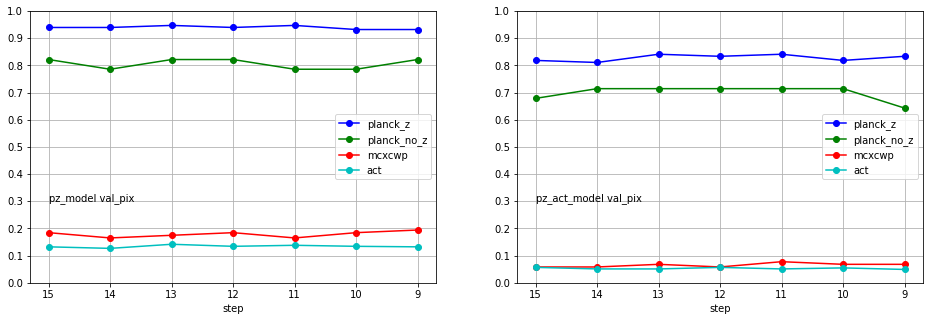

In [15]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))
for i, model in enumerate(['pz', 'pz_act']):
    df = dfs[model]
    for cat, c in zip(['planck_z', 'planck_no_z', 'mcxcwp', 'act'], 'bgrc'):
        line, = ax[i].plot(df.index, df[cat], c+'o-')
        line.set_label(cat)
    ax[i].set_xticks(df.index)
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    ax[i].grid()
    ax[i].text(15, 0.3, model+'_model val_pix')
    ax[i].invert_xaxis()
    ax[i].set_xlabel('step')
    ax[i].legend()

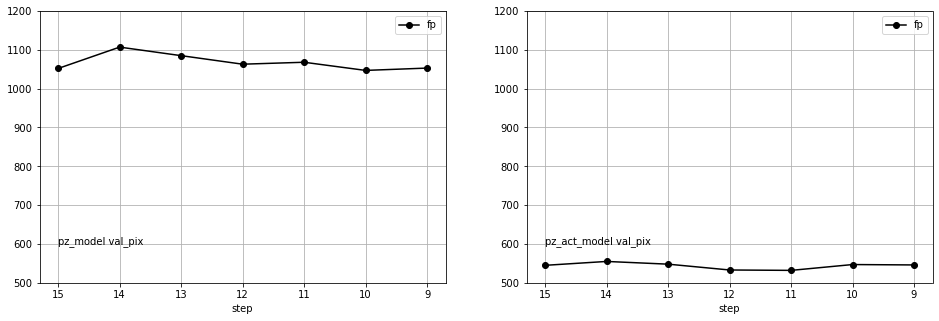

In [16]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))
for i, model in enumerate(['pz', 'pz_act']):
    df = dfs[model]
    line, = ax[i].plot(df.index, df['fp'], 'ko-')
    line.set_label('fp')
    ax[i].set_xticks(df.index)
    ax[i].set_yticks(np.arange(500, 1300, 100))
    ax[i].grid()
    ax[i].text(15, 600, model+'_model val_pix')
    ax[i].invert_xaxis()
    ax[i].set_xlabel('step')
    ax[i].legend()